In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))
meta_df = pd.read_csv('/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv')
meta_df.head()

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0

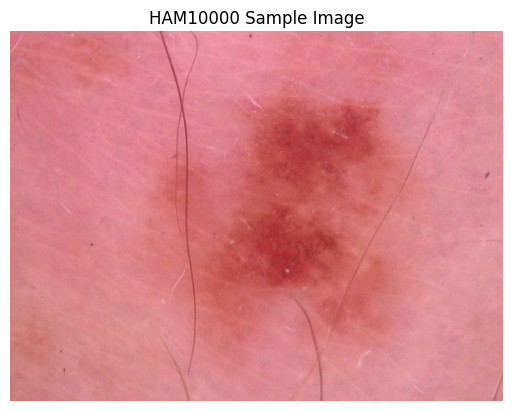

In [33]:
img_path = "/kaggle/input/ham1000-segmentation-and-classification/images/ISIC_0024307.jpg"  # example image

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.title("HAM10000 Sample Image")
plt.show()

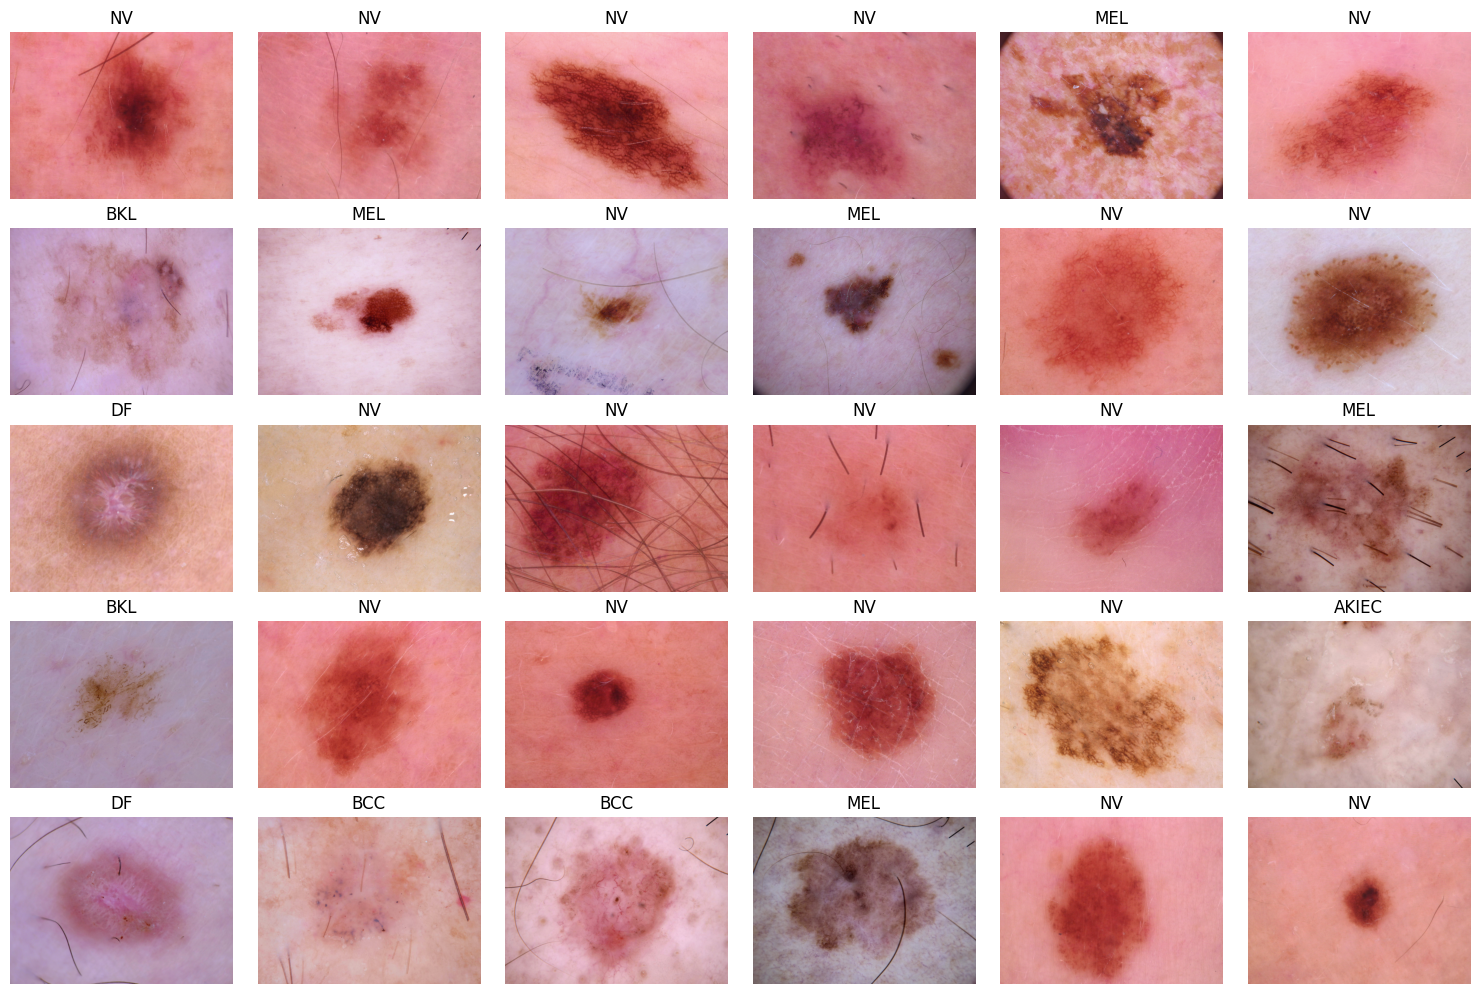

In [34]:
# Folder containing all combined images
image_dir = "/kaggle/input/ham1000-segmentation-and-classification/images"
#image_dir = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1" 
# Show first 10 images
num_images = 30
fig, axes = plt.subplots(5, 6, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img_id = meta_df.image[i] + ".jpg"
    # Select the label columns and find the column name with the maximum value (1.0) for the row
    label_cols = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
    label = meta_df[label_cols].iloc[i].idxmax()
    
    img_path = os.path.join(image_dir, img_id)
    img = cv2.imread(img_path)
    
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.set_title(label)
        ax.axis('off')
    else:
        ax.set_title("Image not found")
        ax.axis('off')

plt.tight_layout()
plt.show()

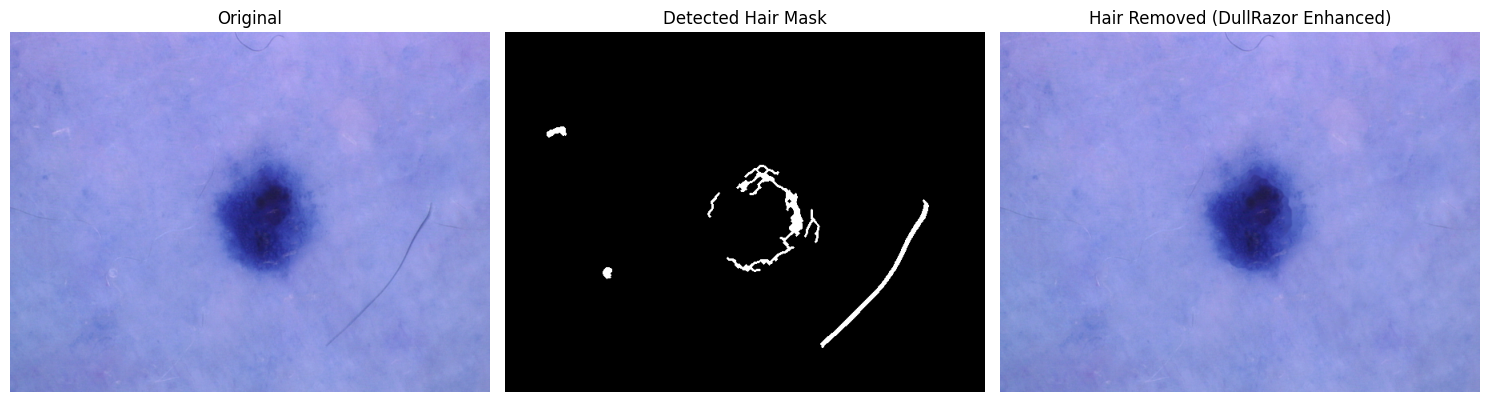

In [35]:
def advanced_dullrazor_hair_removal(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply median blur to reduce noise and preserve edges
    blurred = cv2.medianBlur(gray, 5)

    # Use Canny edge detector to detect hair-like structures
    edges = cv2.Canny(blurred, threshold1=10, threshold2=80)

    # Dilate to connect broken edges (improve mask)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated = cv2.dilate(edges, kernel, iterations=1)

    # Fill small gaps using morphological closing
    closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Optional: Remove small artifacts using connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed, connectivity=8)
    filtered_mask = np.zeros_like(closed)
    for i in range(1, num_labels):  # Skip background (label 0)
        if stats[i, cv2.CC_STAT_AREA] > 20:  # Keep only larger regions
            filtered_mask[labels == i] = 255

    # Inpaint using the refined mask
    inpainted = cv2.inpaint(img, filtered_mask, 3, cv2.INPAINT_NS)
    return inpainted, filtered_mask

# Apply advanced hair removal
processed, hair_mask = advanced_dullrazor_hair_removal(img)

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(hair_mask, cmap='gray')
plt.title("Detected Hair Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(processed)
plt.title("Hair Removed (DullRazor Enhanced)")
plt.axis('off')

plt.tight_layout()
plt.show()



In [36]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# === Paths ===
IMG_DIR = "/kaggle/input/ham1000-segmentation-and-classification/images"
MASK_DIR = "/kaggle/input/ham1000-segmentation-and-classification/masks"

PREPROCESSED_IMG_DIR = "/kaggle/working/final_images"
PREPROCESSED_MASK_DIR = "/kaggle/working/final_masks"
os.makedirs(PREPROCESSED_IMG_DIR, exist_ok=True)
os.makedirs(PREPROCESSED_MASK_DIR, exist_ok=True)

IMG_SIZE = (256, 256)

# === DullRazor Hair Removal ===
def dull_razor(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    se = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    
    # Black-hat to detect hair
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, se)
    
    # Threshold to binary
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    # Dilate to connect nearby hair strands
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)

    # Inpaint
    inpainted = cv2.inpaint(img, mask, inpaintRadius=1, flags=cv2.INPAINT_TELEA)
    return inpainted

# === Full Preprocess Function ===
def full_preprocess_and_save(filename):
    img_path = os.path.join(IMG_DIR, filename)
    img = cv2.imread(img_path)
    if img is None:
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # ✅ DullRazor Hair Removal
    img = dull_razor(img)

    # ✅ Resize and Normalize
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype(np.float32) / 255.0

    # ✅ Save normalized image
    out_img_path = os.path.join(PREPROCESSED_IMG_DIR, filename.replace('.jpg', '.npy'))
    np.save(out_img_path, img)

    # ✅ Load and Process Mask
    mask_name = filename.replace('.jpg', '_segmentation.png')
    mask_path = os.path.join(MASK_DIR, mask_name)
    if not os.path.exists(mask_path):
        return

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return

    mask = cv2.resize(mask, IMG_SIZE)
    mask = (mask > 127).astype(np.uint8)

    # ✅ Save mask
    out_mask_path = os.path.join(PREPROCESSED_MASK_DIR, mask_name.replace('.png', '.npy'))
    np.save(out_mask_path, mask)

# === Apply to All Images ===
image_files = [f for f in os.listdir(IMG_DIR) if f.endswith('.jpg')]

for f in tqdm(image_files):
    full_preprocess_and_save(f)


100%|██████████| 10015/10015 [08:17<00:00, 20.12it/s]


/tmp/ipykernel_36/2216297221.py:35: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_36/2216297221.py:35: UserWarning: Glyph 129658 (\N{STETHOSCOPE}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129658 (\N{STETHOSCOPE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


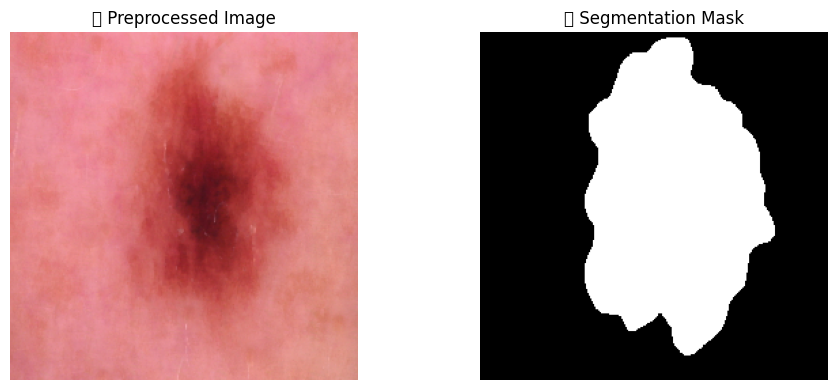

✅ Image shape: (256, 256, 3)
✅ Mask shape:  (256, 256)


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import os

# New test image ID
image_id = "ISIC_0024306"

# Paths to .npy files
img_path = f"/kaggle/working/final_images/{image_id}.npy"
mask_path = f"/kaggle/working/final_masks/{image_id}_segmentation.npy"

# Check if files exist
if not os.path.exists(img_path):
    raise FileNotFoundError(f"❌ Image file not found: {img_path}")
if not os.path.exists(mask_path):
    raise FileNotFoundError(f"❌ Mask file not found: {mask_path}")

# Load files
img = np.load(img_path)   # shape: (256, 256, 3)
mask = np.load(mask_path) # shape: (256, 256)

# Plot
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("🖼️ Preprocessed Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("🩺 Segmentation Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

print("✅ Image shape:", img.shape)
print("✅ Mask shape: ", mask.shape)


/tmp/ipykernel_36/3207682939.py:44: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_36/3207682939.py:44: UserWarning: Glyph 129658 (\N{STETHOSCOPE}) missing from current font.
  plt.tight_layout()


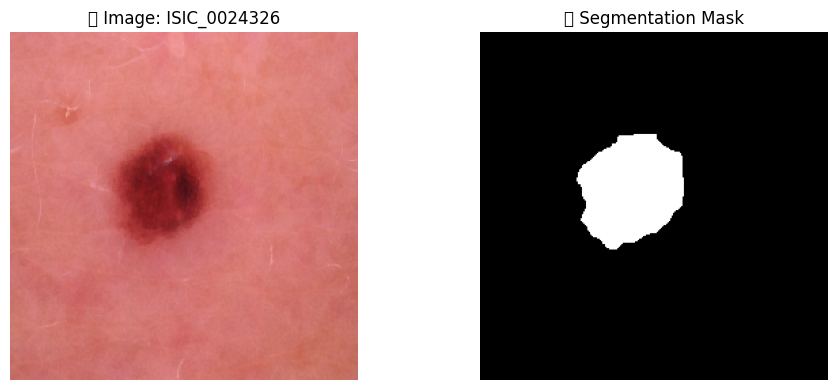

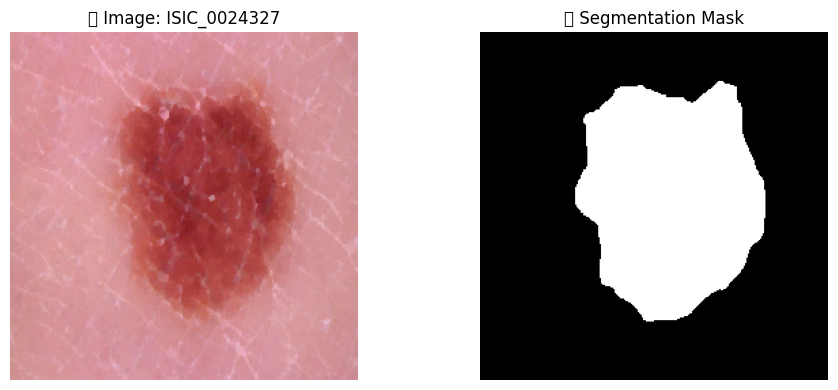

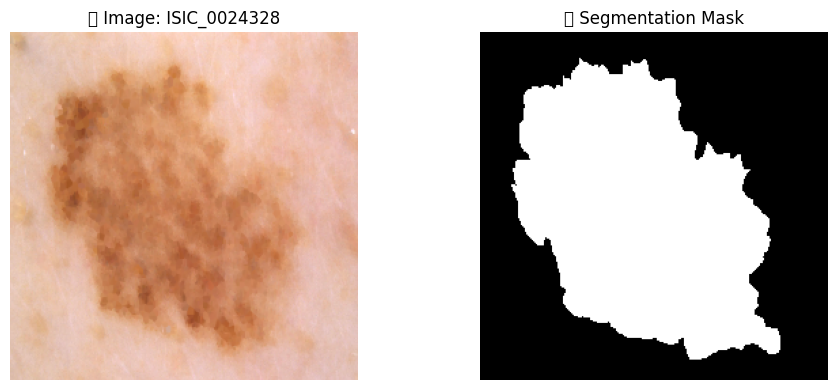

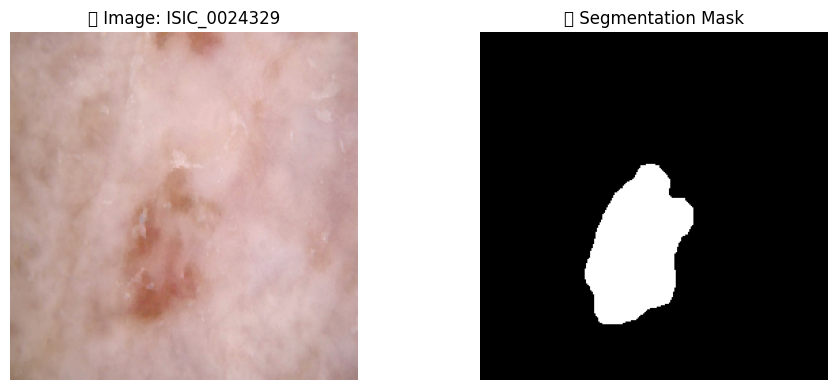

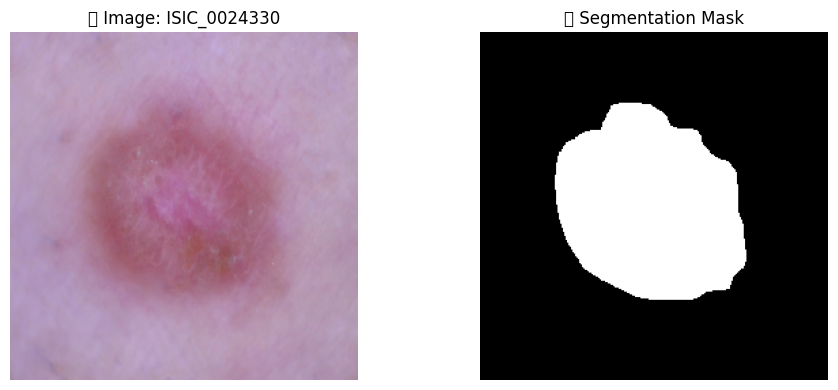

In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Paths to final outputs
PREPROCESSED_IMG_DIR = "/kaggle/working/final_images"
PREPROCESSED_MASK_DIR = "/kaggle/working/final_masks"

# === Select new range of samples ===
start_idx = 20
end_idx = 25

# Get list of image files
image_files = sorted([f for f in os.listdir(PREPROCESSED_IMG_DIR) if f.endswith('.npy')])[start_idx:end_idx]

# === Loop over selected image-mask pairs ===
for idx, filename in enumerate(image_files):
    img_path = os.path.join(PREPROCESSED_IMG_DIR, filename)
    mask_name = filename.replace(".npy", "_segmentation.npy")
    mask_path = os.path.join(PREPROCESSED_MASK_DIR, mask_name)

    # Check existence
    if not os.path.exists(mask_path):
        print(f"⚠️ Skipping {filename} — no matching mask found.")
        continue

    # Load data
    img = np.load(img_path)      # shape: (256, 256, 3)
    mask = np.load(mask_path)    # shape: (256, 256)

    # Display
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"🖼️ Image: {filename.replace('.npy', '')}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("🩺 Segmentation Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
Epoch 1/5 [Val]: 100%|██████████| 126/126 [00:07<00:00, 17.55it/s]


📘 Epoch 1 | Train Loss: 0.2981 | Val Loss: 0.2079
    ↳ Train Dice: 0.8526, IoU: 0.8167
    ↳ Val   Dice: 0.8844, IoU: 0.8616
✅ Saved best model!


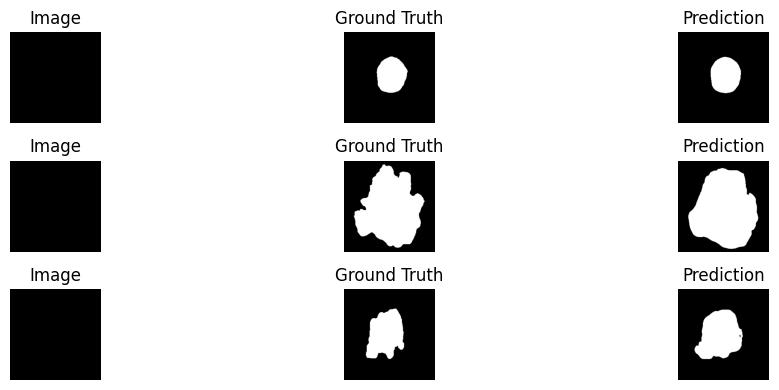

Epoch 2/5 [Val]: 100%|██████████| 126/126 [00:07<00:00, 17.44it/s]


📘 Epoch 2 | Train Loss: 0.2137 | Val Loss: 0.2281
    ↳ Train Dice: 0.8995, IoU: 0.8557
    ↳ Val   Dice: 0.8799, IoU: 0.8378


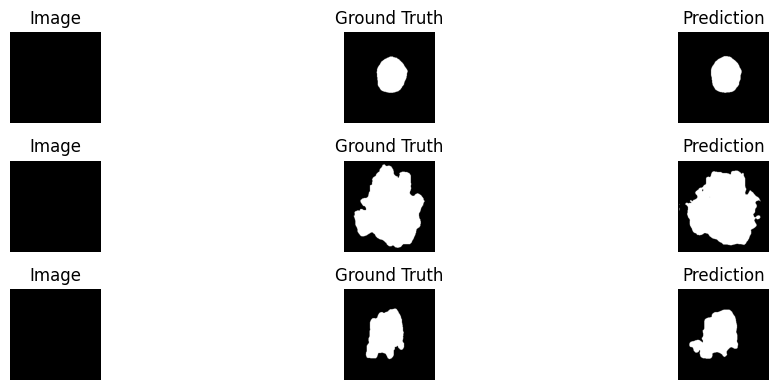

Epoch 3/5 [Val]: 100%|██████████| 126/126 [00:07<00:00, 17.44it/s]


📘 Epoch 3 | Train Loss: 0.1953 | Val Loss: 0.2123
    ↳ Train Dice: 0.9085, IoU: 0.8657
    ↳ Val   Dice: 0.8855, IoU: 0.8498


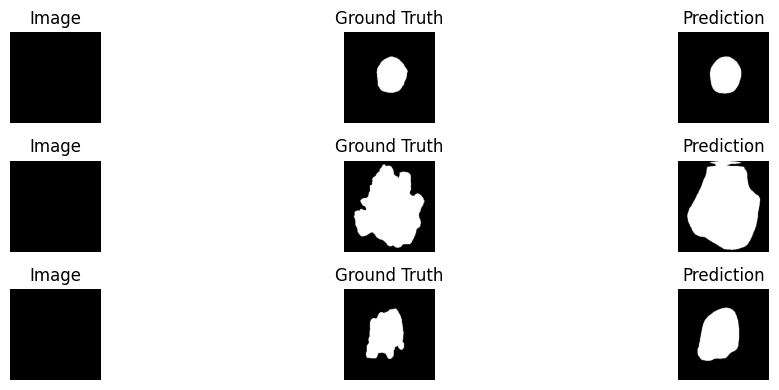

Epoch 4/5 [Val]: 100%|██████████| 126/126 [00:07<00:00, 17.40it/s]


📘 Epoch 4 | Train Loss: 0.1925 | Val Loss: 0.2830
    ↳ Train Dice: 0.9109, IoU: 0.8689
    ↳ Val   Dice: 0.8617, IoU: 0.8080


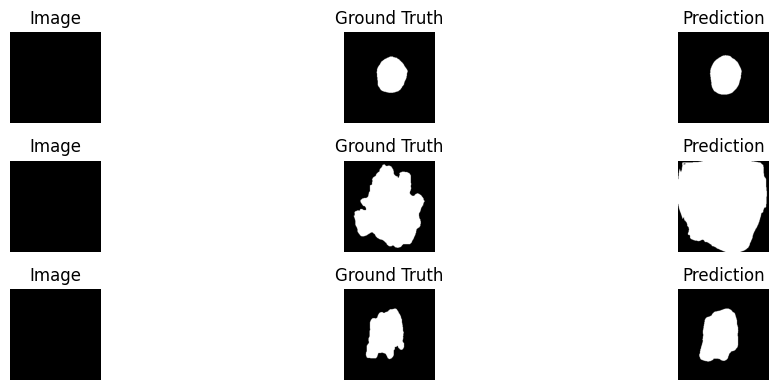

Epoch 5/5 [Val]: 100%|██████████| 126/126 [00:07<00:00, 17.70it/s]


📘 Epoch 5 | Train Loss: 0.1684 | Val Loss: 0.1557
    ↳ Train Dice: 0.9210, IoU: 0.8823
    ↳ Val   Dice: 0.9178, IoU: 0.8848
✅ Saved best model!


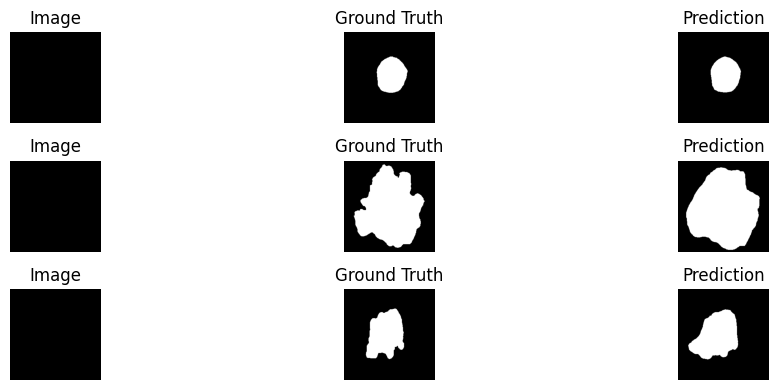

In [39]:
# Install SMP + Albumentations
!pip install -q segmentation-models-pytorch albumentations

# Now import
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import segmentation_models_pytorch as smp
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt


# ---------------- Dataset ----------------
class LesionDataset(Dataset):
    def __init__(self, image_dir, mask_dir, file_list, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        image_name = self.file_list[idx]
        mask_name = image_name.replace(".npy", "_segmentation.npy")

        image = np.load(os.path.join(self.image_dir, image_name))
        mask = np.load(os.path.join(self.mask_dir, mask_name))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0).float()  # (1, H, W)
        else:
            image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1)
            mask = torch.tensor(mask, dtype=torch.float).unsqueeze(0)

        return image, mask

# ---------------- Transforms ----------------
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

# ---------------- Loss Functions ----------------
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

def iou_score(pred, target, threshold=0.5, eps=1e-6):
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum()
    union = ((pred + target) >= 1).float().sum()
    return (intersection + eps) / (union + eps)

# ---------------- Paths ----------------
IMG_DIR = "/kaggle/working/final_images"
MASK_DIR = "/kaggle/working/final_masks"
all_files = sorted([f for f in os.listdir(IMG_DIR) if f.endswith('.npy')])

# ---------------- Dataset Split ----------------
val_size = int(0.1 * len(all_files))
train_size = len(all_files) - val_size
train_files, val_files = all_files[:train_size], all_files[train_size:]

train_dataset = LesionDataset(IMG_DIR, MASK_DIR, train_files, transform=train_transform)
val_dataset = LesionDataset(IMG_DIR, MASK_DIR, val_files, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# ---------------- Model ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.DeepLabV3Plus(encoder_name="resnet50", in_channels=3, classes=1).to(device)

# ---------------- Optimizer & Scheduler ----------------
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# ---------------- Training Loop ----------------
best_val_loss = float("inf")
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_dice = 0
    train_iou = 0

    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)

        bce = criterion(outputs, masks)
        dice = dice_loss(outputs, masks)
        loss = bce + dice

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += 1 - dice.item()
        train_iou += iou_score(outputs, masks).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_train_dice = train_dice / len(train_loader)
    avg_train_iou = train_iou / len(train_loader)

    # ---------------- Validation ----------------
    model.eval()
    val_loss = 0
    val_dice = 0
    val_iou = 0

    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)

            bce = criterion(outputs, masks)
            dice = dice_loss(outputs, masks)
            loss = bce + dice

            val_loss += loss.item()
            val_dice += 1 - dice.item()
            val_iou += iou_score(outputs, masks).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)

    scheduler.step(avg_val_loss)

    print(f"📘 Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"    ↳ Train Dice: {avg_train_dice:.4f}, IoU: {avg_train_iou:.4f}")
    print(f"    ↳ Val   Dice: {avg_val_dice:.4f}, IoU: {avg_val_iou:.4f}")

    # ---------------- Save Best Model ----------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Saved best model!")

    # ---------------- Visualize Prediction ----------------
    imgs, masks = next(iter(val_loader))
    imgs, masks = imgs.to(device), masks.to(device)
    preds = model(imgs)
    preds = torch.sigmoid(preds).cpu().detach().numpy()
    masks = masks.cpu().numpy()

    plt.figure(figsize=(12, 4))
    for i in range(3):
        plt.subplot(3, 3, i * 3 + 1)
        plt.imshow(imgs[i].cpu().permute(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(masks[i][0], cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(3, 3, i * 3 + 3)
        plt.imshow(preds[i][0] > 0.5, cmap="gray")
        plt.title("Prediction")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [52]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

model.eval()

# Initialize metrics
total_iou = 0
total_dice = 0
total_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0
total_samples = 0
conf_matrix = np.array([[0, 0], [0, 0]])

with torch.no_grad():
    for imgs, masks in tqdm(val_loader, desc="Evaluating"):
        imgs = imgs.to(device)
        masks = masks.to(device)

        preds = model(imgs)
        preds = torch.sigmoid(preds)
        preds = (preds > 0.5).float()

        for pred, mask in zip(preds, masks):
            pred = pred.cpu().numpy().flatten().astype(np.uint8)
            mask = mask.cpu().numpy().flatten().astype(np.uint8)

            if np.sum(mask) == 0 and np.sum(pred) == 0:
                continue

            intersection = np.logical_and(pred, mask).sum()
            union = np.logical_or(pred, mask).sum()
            iou = intersection / (union + 1e-6)
            dice = (2 * intersection) / (np.sum(pred) + np.sum(mask) + 1e-6)
            acc = (pred == mask).mean()
            tp = ((pred == 1) & (mask == 1)).sum()
            fp = ((pred == 1) & (mask == 0)).sum()
            fn = ((pred == 0) & (mask == 1)).sum()
            precision = tp / (tp + fp + 1e-6)
            recall = tp / (tp + fn + 1e-6)
            f1 = (2 * precision * recall) / (precision + recall + 1e-6)

            total_iou += iou
            total_dice += dice
            total_accuracy += acc
            total_precision += precision
            total_recall += recall
            total_f1 += f1
            total_samples += 1

            cm = confusion_matrix(mask, pred, labels=[0, 1])
            conf_matrix += cm

# Print results
print(f"\n✅ Evaluation Results (averaged over {total_samples} samples):")
print(f"  - Accuracy      : {total_accuracy / total_samples:.4f}")
print(f"  - Precision     : {total_precision / total_samples:.4f}")
print(f"  - Recall        : {total_recall / total_samples:.4f}")
print(f"  - F1 Score      : {total_f1 / total_samples:.4f}")
print(f"  - Dice Score    : {total_dice / total_samples:.4f}")
print(f"  - IoU (Jaccard) : {total_iou / total_samples:.4f}")
print(f"  - Confusion Matrix:\n{conf_matrix}")


Evaluating: 100%|██████████| 126/126 [00:12<00:00,  9.85it/s]


✅ Evaluation Results (averaged over 1001 samples):
  - Accuracy      : 0.9714
  - Precision     : 0.9597
  - Recall        : 0.9273
  - F1 Score      : 0.9375
  - Dice Score    : 0.9375
  - IoU (Jaccard) : 0.8896
  - Confusion Matrix:
[[49348983   673301]
 [ 1200801 14378451]]


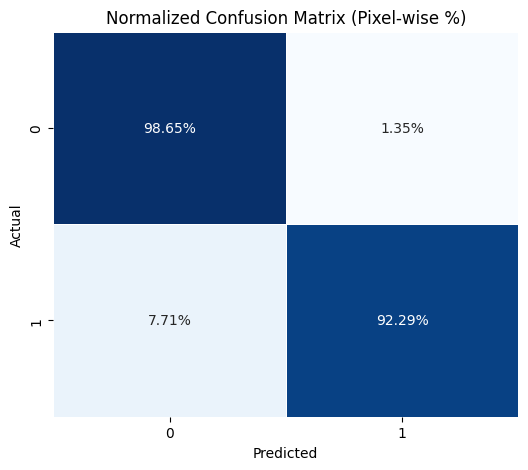

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming conf_matrix is a 2x2 NumPy array from pixel-wise evaluation
# Example: conf_matrix = np.array([[TN, FP], [FN, TP]])

# Normalize the confusion matrix row-wise (Actual class-wise)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)

# Plot normalized confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2%", cmap="Blues", cbar=False, linewidths=0.5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix (Pixel-wise %)")
plt.show()


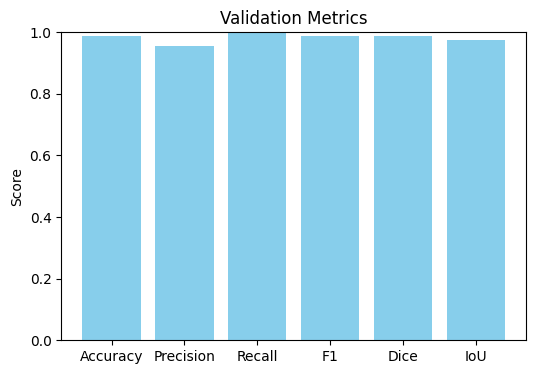

In [45]:
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Dice', 'IoU']
values = [acc, prec, recall, f1, dice, iou]

plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1)
plt.title('Validation Metrics')
plt.ylabel('Score')
plt.show()


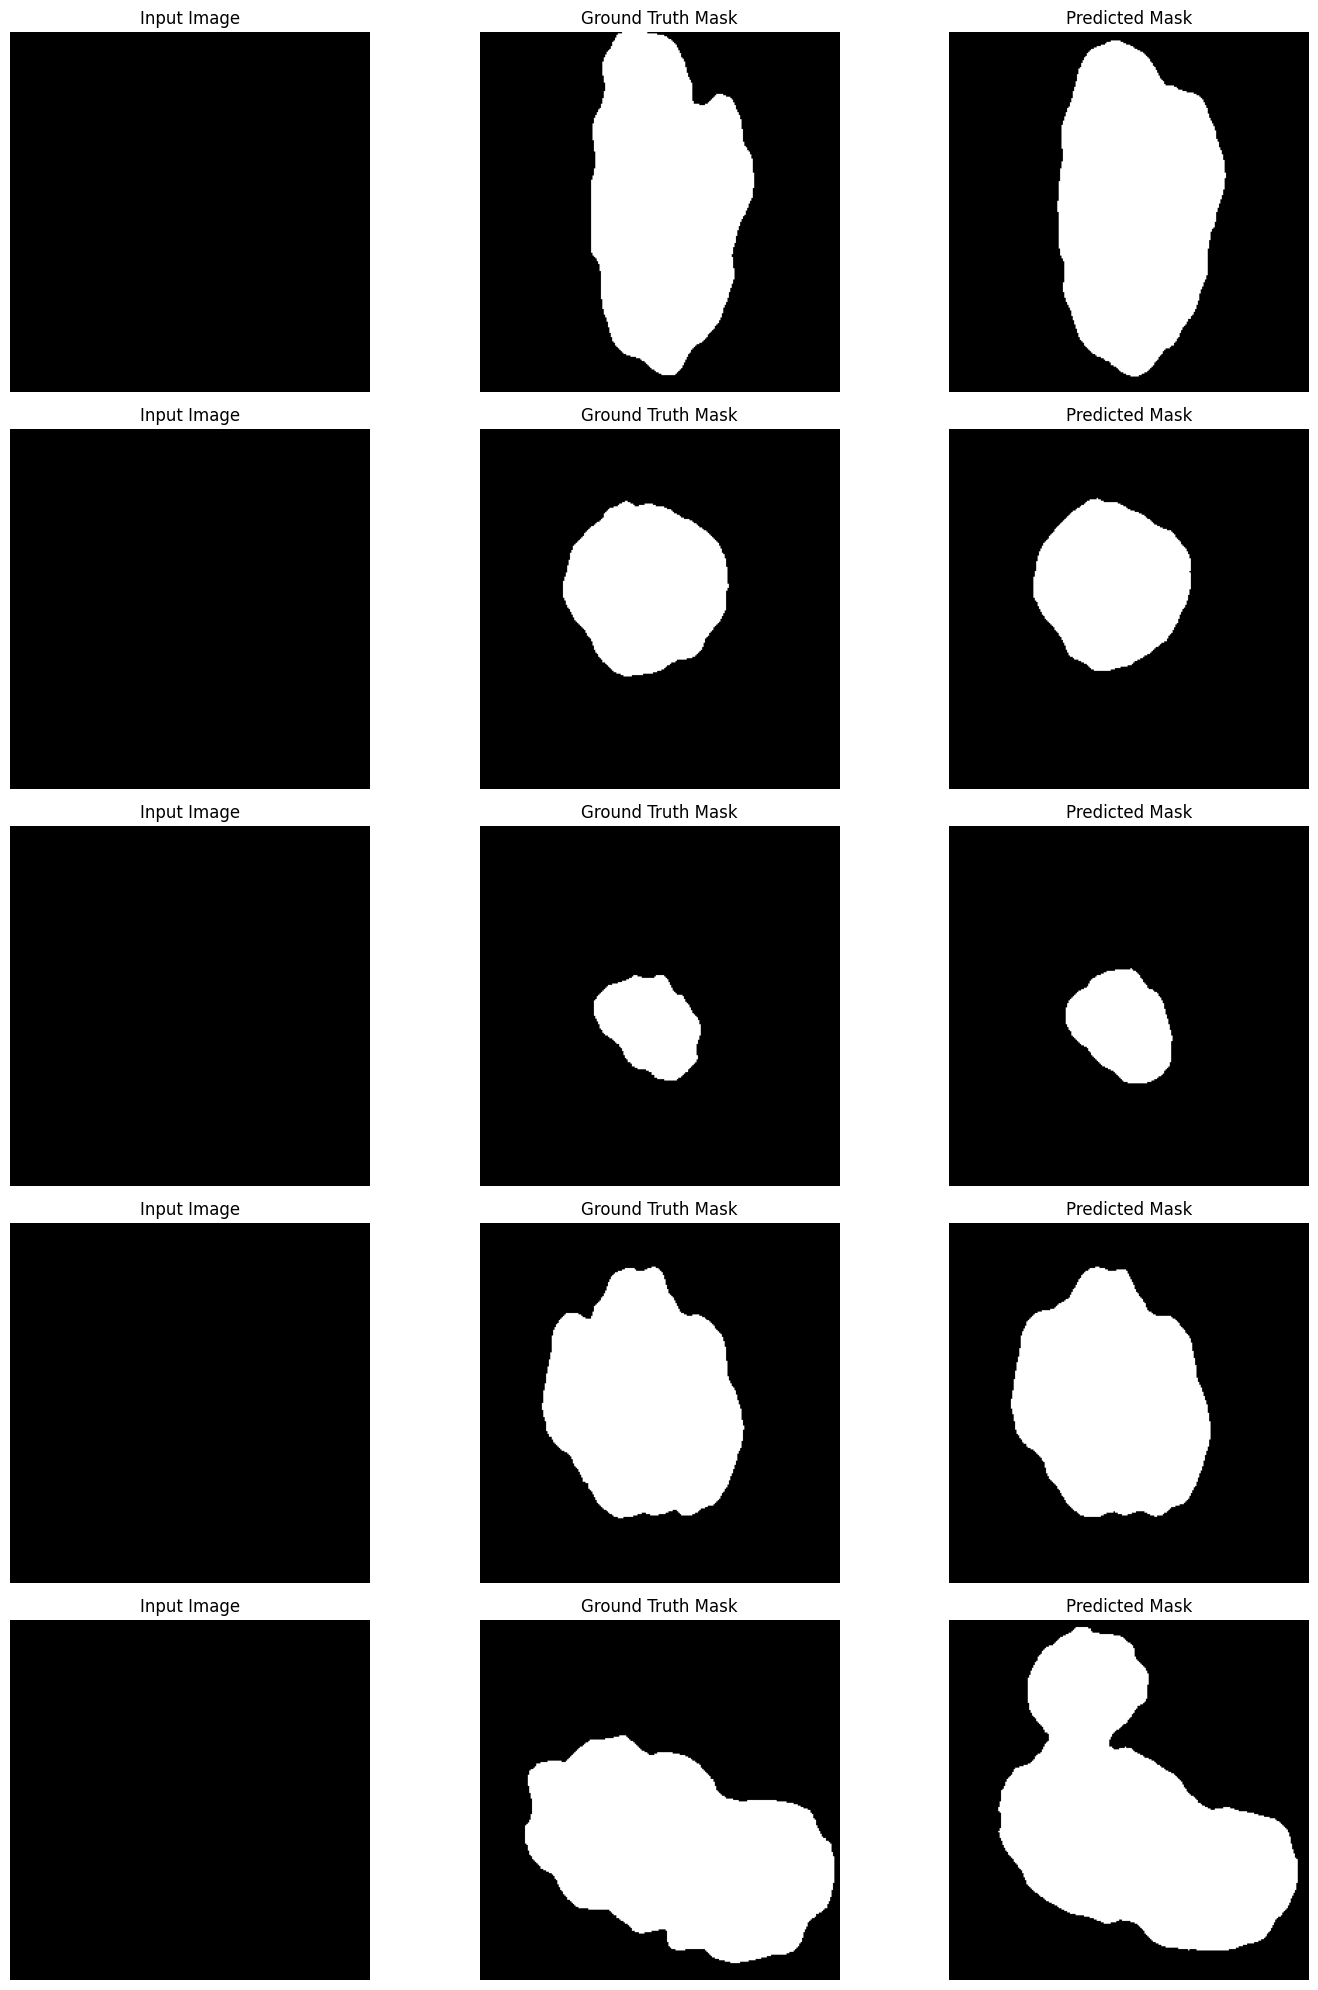

In [48]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Ensure model is in eval mode
model.eval()

num_samples = 5
indices = np.random.choice(len(val_dataset), num_samples, replace=False)

plt.figure(figsize=(15, num_samples * 4))

for i, idx in enumerate(indices):
    img_tensor, mask_tensor = val_dataset[idx]
    img = img_tensor.numpy().transpose(1, 2, 0)
    mask = mask_tensor.numpy().squeeze()

    with torch.no_grad():
        input_tensor = img_tensor.unsqueeze(0).to(device)
        output = model(input_tensor)  # FIXED LINE
        pred = torch.sigmoid(output).squeeze().cpu().numpy()
        pred_mask = (pred > 0.5).astype(np.uint8)

    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()
